# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral

import Sobol: SobolSeq
import LinearAlgebra: norm

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1423
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


## Single correlated atom coupled to a bath level

System parameters

In [2]:
β = 10.;         # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
#ϵ = [-0.1, +0.1] # Bath energy levels
ϵ = [-1.0, +1.0] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [3]:
nt = 2;
ntau = 9;
#ntau = 1001;
#ntau = 5001;
tmax = 1.0;

Exact Diagonalization

In [4]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [5]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [6]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

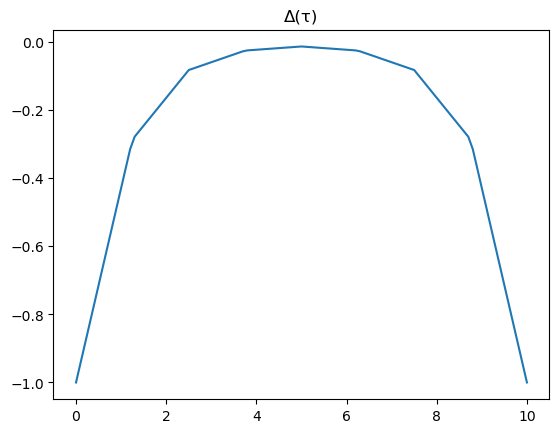

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XaELc/src/init.jl:198
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/hugstr/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [7]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

tau = Array(LinRange(0, β, 101))

b = contour[kd.imaginary_branch]
t0 = b(tau[1])
times = [ b(t/β) for t in tau ]
vals = [ Δ(t, t0) for t in times ]

plt.title("Δ(τ)")
plt.plot(tau, imag.(vals), "-");

Pseudo Particle Strong Coupling Expansion

In [8]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

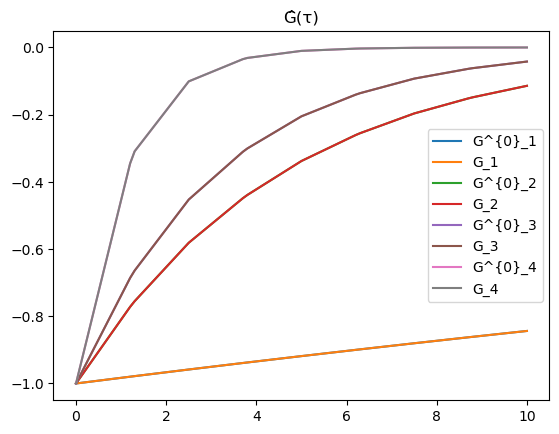

In [9]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

plt.title("Ĝ(τ)")
for (idx, G_s) in enumerate(ppsc_exp.P0)
    vals = [ G_s(t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G^{0}_$idx")

    vals = [ ppsc_exp.P[idx](t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G_$idx")
end

plt.legend(loc="best");

2nd order inchworm diagram on the imaginary branch

In [10]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

for t in tau_grid
    println(imag(t.bpoint.val))
end

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.5 # Inchworm split time at 0.8β
#τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w_idx = 1 + Int(τ_w_pos * (ntau - 1))
τ_w = tau_grid[τ_w_idx]
println(τ_w)

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

0.0
-1.25
-2.5
-3.75
-5.0
-6.25
-7.5
-8.75
-10.0
Keldysh.TimeGridPoint(7, 5, Keldysh.BranchPoint(0.0 - 5.0im, 0.5, Keldysh.imaginary_branch))


Quasi Monte Carlo integration over a $d = 3$ domain

In [11]:
function second_order_diag_eval(τ)
    # Loop over spin indices of hybridization lines
    sum = deepcopy(init_0)
    for index1 = 1:2, index2 = 1:2
        # 4 arrangements of creation and annihilation operators
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
    end
    return sum
end

second_order_diag_eval (generic function with 1 method)

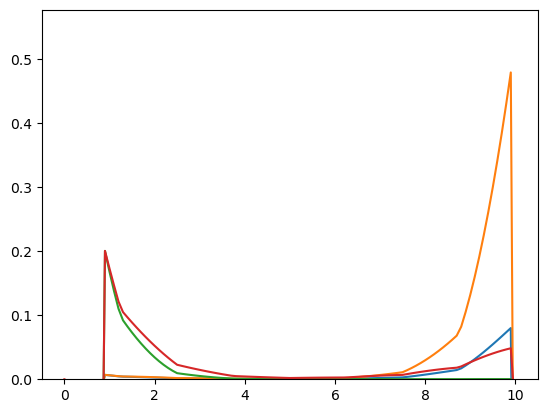

t1 = Keldysh.BranchPoint(0.0 - 0.8999999999999999im, 0.09, Keldysh.imaginary_branch)


(0.0, 0.5775929841156422)

In [12]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

t1 = b(tau[10]/β)
println("t1 = $t1")

vals = [ second_order_diag_eval([b(t/β), t1, t0]) for t in tau ]
#println(vals)

for s in 1:4
    val_s = [ d[s][2] for d in vals ]
    val_s = vcat(val_s...)    
    #println(val_s)
    plt.plot(tau, imag.(val_s))
end

plt.ylim(bottom=0)

In [13]:
import MultiQuad: tplquad

func_sector(z, y, x, sector) = -imag(second_order_diag_eval([b(z/β), b(y/β), b(x/β)])[sector][2][1, 1])

tau_w = τ_w_pos*β

quad_res = [ tplquad((z,y,x) -> func_sector(z, y, x, s), 
        0, tau_w, x->x, x->tau_w, (x,y)->y, (x,y)->tau_w, rtol=1e-3, atol=1e-3) for s in 1:4]

error = [ s[2] for s in quad_res ]
integral = [ s[1] for s in quad_res ]

println("error = $error")
println("integral = $integral")

error = [0.00043035670848272367, 0.0003517801774142529, 0.0009845413782478315, 0.0009646031714744604]
integral = [-0.032947153190995594, -0.03281147654453524, -0.3043858990802257, -0.2992408972438132]


# Delaunay triangulation and integration

In [14]:
points = Array{Float64, 2}(undef, 3, 0)

tau_vals = [-imag(t.bpoint.val) for t in tau_grid]
for i = 1:τ_w_idx
    for j = i:τ_w_idx
        for k = j:τ_w_idx
            points = cat(points, [tau_vals[i], tau_vals[j], tau_vals[k]]; dims=2)
        end
    end
end
points';

In [15]:
import PyCall as py;
sp = py.pyimport("scipy.spatial");

dl = sp.Delaunay(points', furthest_site=false);

simplices = py.py"$dl.simplices";

In [16]:
qp = py.pyimport("quadpy");
np = py.pyimport("numpy");

order = 10;
calc = qp.t3.get_good_scheme(order);

#scalar_integrand(x) = imag(second_order_diag_eval([b(x[1]), b(x[2]), b(x[3])])[3][2][1, 1])
scalar_integrand(x, sector) = func_sector(x[1], x[2], x[3], sector)

function integrand(x, sector)
    vals = []
    for i = 1:size(x, 2)
        push!(vals, scalar_integrand(x[:, i], sector))
    end
    vals
end

val = [0., 0., 0., 0.]
for i = 1:size(dl.simplices, 1)
    vidx = dl.simplices[i, :]
    tetra = Array{Float64}(Base.undef, 3, 0)
    for j = vidx
        tetra = cat(tetra, points[:, 1+j]; dims=2)
    end
    res = [ calc.integrate(x -> integrand(x, s), np.array(tetra')) for s in [1, 2, 3, 4] ]
    val += res
    #println(tetra, res)
    #println(res)
    #if res == NaN
    #    println(tetra)
    #end
end

println()
println("integral = $integral")
println("val      = $val")

#using Test
#@test val ≈ integral


integral = [-0.032947153190995594, -0.03281147654453524, -0.3043858990802257, -0.2992408972438132]
val      = [-0.037346155850047746, -0.03744590191746948, -0.3042227066494704, -0.2996648420993295]


## Numerical experiments

In [17]:
function do_2nd_order_inchworm_diagram(τ_qmc, N, seq)
    qmc_time_ordered_integral(3, contour,
                              τ_i.bpoint, τ_w.bpoint,
                              init = deepcopy(init_0),
                              seq = seq, τ = τ_qmc, N = N) do τ
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        sum
    end
end

do_2nd_order_inchworm_diagram (generic function with 1 method)

In [18]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

# Scan a range of sample numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = zeros(Int, N_points)
    chunks = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for i = 1:N_points
        N = i * N_step
        N_list[i] = N
        
        seq = SobolSeq(3)
        seq = skip(seq, N_step * N_points) # Acclaimed better uniformity see Sobol.jl docs
        seq = skip(seq, N - N_step, exact=true)
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N_step, seq)
        chunks[:, i] = [val[s][2][1] for s = 1:4]
        
        println("N = $N, val = ", chunks[:, i])
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_points
        results[:, i] /= i
    end
    (N_list, results)
end

# Scan a range of sample numbers N without optimizations
function scan_N_range_unopt(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = collect(range(N_step, step=N_step, length=N_points))
    results = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for (i, N) in collect(enumerate(N_list))
        N_list[i] = N
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N, SobolSeq(3))
        
        results[:, i] = [val[s][2][1] for s=1:4]
        println("N = $N, res = ", results[:, i])
    end
    (N_list, results)
end

using HDF5
function h5_write_results(group_name, ref, τ_qmc, N_range, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        if group_name in keys(file)
            delete_object(file, group_name)
        end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_range", collect(N_range))
        write(g, "results", results)
        write(g, "div", div)
    end
end

h5_write_results (generic function with 1 method)

In [19]:
Threads.nthreads()

8

In [43]:
#τ_qmc = 4.0β
#τ_qmc = 2.0β
τ_qmc = 1.0β
#τ_qmc = 0.5β

N_step = 100000
N_points = 8 * 1000
#N_points = 24 * 10

#N_step = 10000
#N_points = 24 * 100

#N_step = 10000
#N_points = 2000

N_list, results = scan_N_range(τ_qmc, N_step, N_points);

## Check against the unoptimized version
#N_list_unopt, results_unopt = scan_N_range_unopt(τ_qmc, N_step, N_points)
#@assert N_list == N_list_unopt
#@assert isapprox(norm(results - results_unopt, Inf), 0, atol=1e-14)

τ_qmc = 10.0
N = 100000, val = ComplexF64[-0.03900027709298336 + 0.0im, -0.03924773640495726 + 0.0im, -0.3245777512542999 + 0.0im, -0.3250233264688718 + 0.0im]
N = 60100000, val = ComplexF64[-0.035624362907922924 + 0.0im, -0.03551605635611549 + 0.0im, -0.27504183963516704 + 0.0im, -0.2673636370286153 + 0.0im]
N = 40100000, val = ComplexF64[-0.03683689720646758 + 0.0im, -0.03685915922832233 + 0.0im, -0.29515989211195304 + 0.0im, -0.288912725989487 + 0.0im]
N = 50100000, val = ComplexF64[-0.03612775596248438 + 0.0im, -0.03614487699977622 + 0.0im, -0.2891280713487884 + 0.0im, -0.28297417106562384 + 0.0im]
N = 20100000, val = ComplexF64[-0.03718581010608802 + 0.0im, -0.03723872956442841 + 0.0im, -0.3032848878945807 + 0.0im, -0.2990153909817306 + 0.0im]
N = 30100000, val = ComplexF64[-0.03764224410399324 + 0.0im, -0.03761755007191852 + 0.0im, -0.31320707365757366 + 0.0im, -0.3049589615738388 + 0.0im]
N = 70100000, val = ComplexF64[-0.03914591320891775 + 0.0im, -0.039397173345877376 + 0.0im,

N = 1000000, val = ComplexF64[-0.038591198324929736 + 0.0im, -0.03896790631568488 + 0.0im, -0.3224188175351313 + 0.0im, -0.321597933397224 + 0.0im]
N = 51000000, val = ComplexF64[-0.03681939293947537 + 0.0im, -0.036890998161531234 + 0.0im, -0.29257882965751775 + 0.0im, -0.2898125139995626 + 0.0im]
N = 41000000, val = ComplexF64[-0.039427019996745194 + 0.0im, -0.03955516282245767 + 0.0im, -0.33650326074158365 + 0.0im, -0.3343799772018032 + 0.0im]
N = 71000000, val = ComplexF64[-0.03759528911095621 + 0.0im, -0.037860863673897134 + 0.0im, -0.3073179851832671 + 0.0im, -0.30471109979975025 + 0.0im]
N = 61000000, val = ComplexF64[-0.03776071921213826 + 0.0im, -0.03773946519458685 + 0.0im, -0.31570235309196165 + 0.0im, -0.31028856251926173 + 0.0im]
N = 11000000, val = ComplexF64[-0.03753182974731623 + 0.0im, -0.0377279005011992 + 0.0im, -0.3035976404086439 + 0.0im, -0.30065880012012824 + 0.0im]
N = 21000000, val = ComplexF64[-0.03858495767325892 + 0.0im, -0.03868712180168099 + 0.0im, -0.32513

N = 1900000, val = ComplexF64[-0.03643501340672379 + 0.0im, -0.03647783476704071 + 0.0im, -0.29073881131806284 + 0.0im, -0.2852027166185854 + 0.0im]
N = 41900000, val = ComplexF64[-0.03718608469414418 + 0.0im, -0.03715671428622501 + 0.0im, -0.3026325301231298 + 0.0im, -0.29462038327005124 + 0.0im]
N = 51900000, val = ComplexF64[-0.03717503949393166 + 0.0im, -0.037052006398508606 + 0.0im, -0.30314109973544656 + 0.0im, -0.2955043731544184 + 0.0im]
N = 71900000, val = ComplexF64[-0.036927045714882006 + 0.0im, -0.03686362769677863 + 0.0im, -0.2971483028148756 + 0.0im, -0.2864156761147806 + 0.0im]
N = 21900000, val = ComplexF64[-0.036480016334079594 + 0.0im, -0.036404088482107 + 0.0im, -0.2924015341244021 + 0.0im, -0.2856787539312008 + 0.0im]
N = 61900000, val = ComplexF64[-0.03700528027094566 + 0.0im, -0.037116602502547294 + 0.0im, -0.2988146175828631 + 0.0im, -0.2936440930143936 + 0.0im]
N = 31900000, val = ComplexF64[-0.03617046283725945 + 0.0im, -0.03614662658690768 + 0.0im, -0.28349191

N = 2800000, val = ComplexF64[-0.03869069396992735 + 0.0im, -0.03873741343642035 + 0.0im, -0.33089291025085316 + 0.0im, -0.32484716626109134 + 0.0im]
N = 52800000, val = ComplexF64[-0.037714435903745576 + 0.0im, -0.03793929690197991 + 0.0im, -0.30567634148809564 + 0.0im, -0.30523912369827694 + 0.0im]
N = 42800000, val = ComplexF64[-0.036047618913333794 + 0.0im, -0.03589057661824033 + 0.0im, -0.2878204834868407 + 0.0im, -0.27669889540903747 + 0.0im]
N = 62800000, val = ComplexF64[-0.03739617163693998 + 0.0im, -0.03776370668157266 + 0.0im, -0.29849019663204224 + 0.0im, -0.30138507657735353 + 0.0im]
N = 72800000, val = ComplexF64[-0.03693554286104059 + 0.0im, -0.03718255884259146 + 0.0im, -0.29941682310565987 + 0.0im, -0.2976518435086238 + 0.0im]
N = 12800000, val = ComplexF64[-0.03758815095201725 + 0.0im, -0.03778841696806076 + 0.0im, -0.30694496824098466 + 0.0im, -0.30407876088258035 + 0.0im]
N = 22800000, val = ComplexF64[-0.0384901474616241 + 0.0im, -0.03870716850532051 + 0.0im, -0.32

N = 3700000, val = ComplexF64[-0.03766220023995596 + 0.0im, -0.03783610082247895 + 0.0im, -0.3067369288978265 + 0.0im, -0.30087017020112405 + 0.0im]
N = 53700000, val = ComplexF64[-0.03657294606603629 + 0.0im, -0.03638373607062107 + 0.0im, -0.2946818983286081 + 0.0im, -0.2836669072835077 + 0.0im]
N = 43700000, val = ComplexF64[-0.03779818380298977 + 0.0im, -0.03782512086811225 + 0.0im, -0.31105927349846935 + 0.0im, -0.304587697747386 + 0.0im]
N = 63700000, val = ComplexF64[-0.037257128049679226 + 0.0im, -0.03740367289251319 + 0.0im, -0.30102834372055365 + 0.0im, -0.29673063254768567 + 0.0im]
N = 13700000, val = ComplexF64[-0.036035085330169594 + 0.0im, -0.03597288430915835 + 0.0im, -0.2851813462386396 + 0.0im, -0.27872646423387215 + 0.0im]
N = 73700000, val = ComplexF64[-0.03607335102677583 + 0.0im, -0.03622678665539318 + 0.0im, -0.2775993182072825 + 0.0im, -0.2719047657394503 + 0.0im]
N = 23700000, val = ComplexF64[-0.03654986428984738 + 0.0im, -0.03666123020323777 + 0.0im, -0.2885501

N = 4600000, val = ComplexF64[-0.036945476680747796 + 0.0im, -0.03719329244536852 + 0.0im, -0.2932659318131024 + 0.0im, -0.2916502997811156 + 0.0im]
N = 74500000, val = ComplexF64[-0.03715657344653138 + 0.0im, -0.03725176973372824 + 0.0im, -0.30065002230374627 + 0.0im, -0.2971191127576724 + 0.0im]
N = 14500000, val = ComplexF64[-0.036542578167022645 + 0.0im, -0.036590999821023616 + 0.0im, -0.2956874938166447 + 0.0im, -0.28917285677562665 + 0.0im]
N = 24500000, val = ComplexF64[-0.03625298275091279 + 0.0im, -0.03630479002552281 + 0.0im, -0.28632335903114625 + 0.0im, -0.2817493546494737 + 0.0im]
N = 34500000, val = ComplexF64[-0.03810654957114067 + 0.0im, -0.03850092248887218 + 0.0im, -0.31850848643566965 + 0.0im, -0.32254701601497127 + 0.0im]
N = 54600000, val = ComplexF64[-0.0365973721081897 + 0.0im, -0.036621152384887314 + 0.0im, -0.2920983511464326 + 0.0im, -0.2851794584218372 + 0.0im]
N = 44600000, val = ComplexF64[-0.03757461555744622 + 0.0im, -0.03784967700654833 + 0.0im, -0.30472

N = 5500000, val = ComplexF64[-0.03703134217999934 + 0.0im, -0.03724325856399936 + 0.0im, -0.2955887270244599 + 0.0im, -0.29077516039216716 + 0.0im]
N = 75400000, val = ComplexF64[-0.03851100089963949 + 0.0im, -0.03874595233491901 + 0.0im, -0.3188329076152836 + 0.0im, -0.316248138125078 + 0.0im]
N = 15400000, val = ComplexF64[-0.037876071049160104 + 0.0im, -0.037834093641782855 + 0.0im, -0.32045375726287384 + 0.0im, -0.3143909094902201 + 0.0im]
N = 35400000, val = ComplexF64[-0.038187946474063046 + 0.0im, -0.03848801544329066 + 0.0im, -0.3152541012290385 + 0.0im, -0.31673633281296915 + 0.0im]
N = 25400000, val = ComplexF64[-0.03793492133890618 + 0.0im, -0.038049962638746986 + 0.0im, -0.31467261683205755 + 0.0im, -0.3095692113625479 + 0.0im]
N = 55500000, val = ComplexF64[-0.03877421434532736 + 0.0im, -0.03921157789730847 + 0.0im, -0.3185275061385601 + 0.0im, -0.32037063772594637 + 0.0im]
N = 45500000, val = ComplexF64[-0.037433114306805154 + 0.0im, -0.03779502736042368 + 0.0im, -0.3008

N = 6400000, val = ComplexF64[-0.03731026250038049 + 0.0im, -0.03719610200790074 + 0.0im, -0.3124431286853153 + 0.0im, -0.3052289400671057 + 0.0im]
N = 46300000, val = ComplexF64[-0.03701255838392341 + 0.0im, -0.037096413364494984 + 0.0im, -0.3016640229788522 + 0.0im, -0.29644064129067654 + 0.0im]
N = 76300000, val = ComplexF64[-0.039215370765983394 + 0.0im, -0.03962608885258154 + 0.0im, -0.3313683722437489 + 0.0im, -0.33542906376913906 + 0.0im]
N = 66300000, val = ComplexF64[-0.03691328731436588 + 0.0im, -0.036896752816280486 + 0.0im, -0.3032655612858013 + 0.0im, -0.2960927633625893 + 0.0im]
N = 16300000, val = ComplexF64[-0.03862472372942667 + 0.0im, -0.038909372650842856 + 0.0im, -0.31892573868153246 + 0.0im, -0.3173136954570667 + 0.0im]
N = 36300000, val = ComplexF64[-0.038926740837448376 + 0.0im, -0.039371135320762994 + 0.0im, -0.32158672484430656 + 0.0im, -0.3228187168140958 + 0.0im]
N = 26300000, val = ComplexF64[-0.03670759779388245 + 0.0im, -0.03670247207515529 + 0.0im, -0.297

N = 7300000, val = ComplexF64[-0.037312810510784764 + 0.0im, -0.037514870518470765 + 0.0im, -0.30287154637346897 + 0.0im, -0.2979195147465656 + 0.0im]
N = 47200000, val = ComplexF64[-0.0371773896268345 + 0.0im, -0.037297749116304846 + 0.0im, -0.2996853784875438 + 0.0im, -0.2941488004701233 + 0.0im]
N = 77200000, val = ComplexF64[-0.03751616676314637 + 0.0im, -0.03775431745463221 + 0.0im, -0.2981308995887657 + 0.0im, -0.29631421946651054 + 0.0im]
N = 67200000, val = ComplexF64[-0.03765440642141467 + 0.0im, -0.03771142495025202 + 0.0im, -0.31448069674229717 + 0.0im, -0.31114219673512705 + 0.0im]
N = 17200000, val = ComplexF64[-0.03649266583575423 + 0.0im, -0.03658781481352839 + 0.0im, -0.2863025001298394 + 0.0im, -0.2825189047515604 + 0.0im]
N = 37200000, val = ComplexF64[-0.03763654857071034 + 0.0im, -0.037568880348879355 + 0.0im, -0.31717419361778765 + 0.0im, -0.3119902322111031 + 0.0im]
N = 27200000, val = ComplexF64[-0.03730737614943048 + 0.0im, -0.0376364856379018 + 0.0im, -0.294108

N = 8200000, val = ComplexF64[-0.03645214146016039 + 0.0im, -0.036595738836058496 + 0.0im, -0.2967328612530464 + 0.0im, -0.29324165100031424 + 0.0im]
N = 48100000, val = ComplexF64[-0.038481120792983915 + 0.0im, -0.03867216034029614 + 0.0im, -0.3228860847263057 + 0.0im, -0.3188303839085235 + 0.0im]
N = 78100000, val = ComplexF64[-0.03690562520879615 + 0.0im, -0.036936205435629164 + 0.0im, -0.298429925090128 + 0.0im, -0.2938311979742173 + 0.0im]
N = 68100000, val = ComplexF64[-0.036315658856947666 + 0.0im, -0.03636848473608885 + 0.0im, -0.2810467480557917 + 0.0im, -0.2753971535891436 + 0.0im]
N = 18100000, val = ComplexF64[-0.035344359233784046 + 0.0im, -0.03539611576276317 + 0.0im, -0.26807279682424695 + 0.0im, -0.26101720666754946 + 0.0im]
N = 38100000, val = ComplexF64[-0.03564852015756385 + 0.0im, -0.035554395538650176 + 0.0im, -0.28258942377676216 + 0.0im, -0.27335786737725526 + 0.0im]
N = 28100000, val = ComplexF64[-0.03658876146303557 + 0.0im, -0.03660038066610492 + 0.0im, -0.301

N = 9100000, val = ComplexF64[-0.03854692887777995 + 0.0im, -0.03852851985405208 + 0.0im, -0.3305821619697323 + 0.0im, -0.32309422406528115 + 0.0im]
N = 79000000, val = ComplexF64[-0.03774598703262952 + 0.0im, -0.03785784585371068 + 0.0im, -0.30433149345448274 + 0.0im, -0.29704213539958896 + 0.0im]
N = 69000000, val = ComplexF64[-0.03816126719335137 + 0.0im, -0.03828779959426029 + 0.0im, -0.32094741787619613 + 0.0im, -0.31676639185733463 + 0.0im]
N = 19000000, val = ComplexF64[-0.03533120356486077 + 0.0im, -0.035008204479093766 + 0.0im, -0.2818955552422935 + 0.0im, -0.27255841072394477 + 0.0im]
N = 39000000, val = ComplexF64[-0.036691068473160324 + 0.0im, -0.0366502175116063 + 0.0im, -0.30396595603651044 + 0.0im, -0.2961852111519625 + 0.0im]
N = 29000000, val = ComplexF64[-0.03770973895161632 + 0.0im, -0.03789704497968554 + 0.0im, -0.305233405371921 + 0.0im, -0.3031087302307377 + 0.0im]
N = 59100000, val = ComplexF64[-0.037703159322762525 + 0.0im, -0.03785340063767946 + 0.0im, -0.30271

N = 10000000, val = ComplexF64[-0.03724634138918366 + 0.0im, -0.03718286316684518 + 0.0im, -0.3038056026501839 + 0.0im, -0.2948384537299032 + 0.0im]
N = 79900000, val = ComplexF64[-0.037302148841990145 + 0.0im, -0.037351657357232386 + 0.0im, -0.30229168290122543 + 0.0im, -0.2964852788767723 + 0.0im]
N = 69900000, val = ComplexF64[-0.03700932135354829 + 0.0im, -0.0370542689063074 + 0.0im, -0.3057911668865219 + 0.0im, -0.3007967808050191 + 0.0im]
N = 19900000, val = ComplexF64[-0.03815283934718844 + 0.0im, -0.0383098513679233 + 0.0im, -0.31741074856419477 + 0.0im, -0.31474564748216344 + 0.0im]
N = 39900000, val = ComplexF64[-0.037057097707954234 + 0.0im, -0.03696878993512247 + 0.0im, -0.29166875680753046 + 0.0im, -0.2842938103862413 + 0.0im]
N = 29900000, val = ComplexF64[-0.03708055492708357 + 0.0im, -0.03737375901381689 + 0.0im, -0.3001130287955149 + 0.0im, -0.30065091552713014 + 0.0im]
N = 60000000, val = ComplexF64[-0.03733437880943495 + 0.0im, -0.03753637369081849 + 0.0im, -0.296272

In [44]:
results[:, end]

4-element Vector{ComplexF64}:
 -0.037355200089617346 + 0.0im
  -0.03745658740714224 + 0.0im
  -0.30435210874395424 + 0.0im
   -0.2998176606040234 + 0.0im

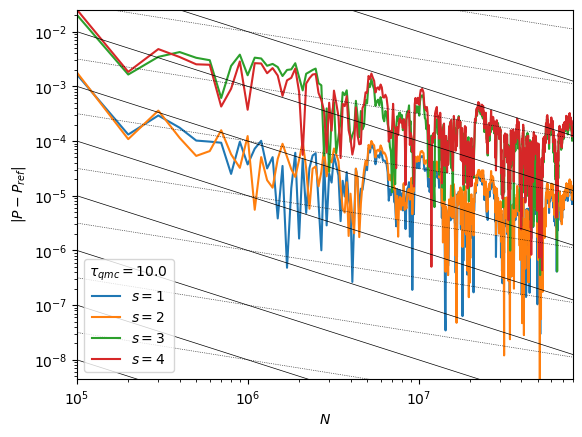

res = [-0.037355200089617346, -0.03745658740714224, -0.30435210874395424, -0.2998176606040234]
ref = [-0.037346155850047746, -0.03744590191746948, -0.3042227066494704, -0.2996648420993295]
diff = [9.044239569599988e-6, 1.0685489672764004e-5, 0.00012940209448386586, 0.0001528185046938968]


In [45]:
ref = val
println("res = $(real(results[:, end]))")
println("ref = $ref")
println("diff = $(abs.(real(results[:, end]) - ref))")

div = results - (ref .* ones(Float64, N_points)')

h5_write_results("tau_qmc_$τ_qmc", ref, τ_qmc, N_list, results, div)

for s=1:4
    plt.loglog(N_list, abs.(div[s, :]), label = "\$s=$s\$")
end

for i = -3:5
    plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
    plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
end

plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_list[1], N_list[end])
plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
plt.legend(title="\$\\tau_{qmc} = $τ_qmc\$")

#plt.text(1e5, 1e-7, "\$\\tau_{qmc} = $τ_qmc\$")

plt.savefig("2nd_order_inchworm_tau$τ_qmc.pdf")

In [ ]:
# Test a single value of the integrand

τ = [tau_grid[end-20].bpoint, tau_grid[end-30].bpoint, tau_grid[end-40].bpoint]
@show τ

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
println(s)